In [37]:
import os
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import skimage as ski
from skimage.transform import resize
import warnings
from scipy.ndimage import uniform_filter
import cmcrameri.cm as cmc
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

import sys


warnings.filterwarnings('ignore')

#Set directories
working_dir = os.getcwd()

#Get parent directory
demo_dir = os.path.dirname(working_dir)

# Import PRINGLE modules
sys.path.append(os.path.join(demo_dir,'PRGL_modules'))  # Add 'utils' to the path
from PRINGLE import *

In [17]:
#Load example data
all_cells = pd.read_csv(os.path.join(working_dir,'chick_example_data.csv'))

no_embryos = len(all_cells['embryo'].unique())

#Define which channel is the midline channel
midline_channel = 'TBRA'

#Pre-compute the epiblast cells 
epi_mask = all_cells['Epiblast'] == True

#Make sure to scale units to microns
pixel_size = 1.1535
all_cells['X'] = all_cells['X']*pixel_size
all_cells['Y'] = all_cells['Y']*pixel_size
all_cells['Z'] = all_cells['Z']*pixel_size

#veiw data
print(all_cells.head())

    label           Z            X            Y      SOX2      TBRA     MSGN1  \
0   77191   85.760167  1453.307625   317.972474  0.150289  0.010793  0.070443   
1  123807  158.246118   539.158550  1446.522452  0.177936  0.531009  0.067224   
2   61814  106.673620  2009.474862   280.128295  0.072354  0.013078  0.064239   
3   88650   83.929893  3123.759079  2118.549955  0.081806  0.028523  0.139074   
4   40615   51.921870  2304.440865   141.625501  0.152210  0.045610  0.069850   

   Epiblast  embryo   Oriented_X  Oriented_Y  TBRA_smoothed  
0     False       3   143.416068  864.535733            NaN  
1     False       4  1138.826950   66.209611            NaN  
2     False       2  -323.989165  837.432683            NaN  
3     False       2 -1166.303729 -825.033072            NaN  
4     False       3  -609.349342  898.724754            NaN  


## 1. Flatten embryo

#### Orient embryo to major axis of TBra expression

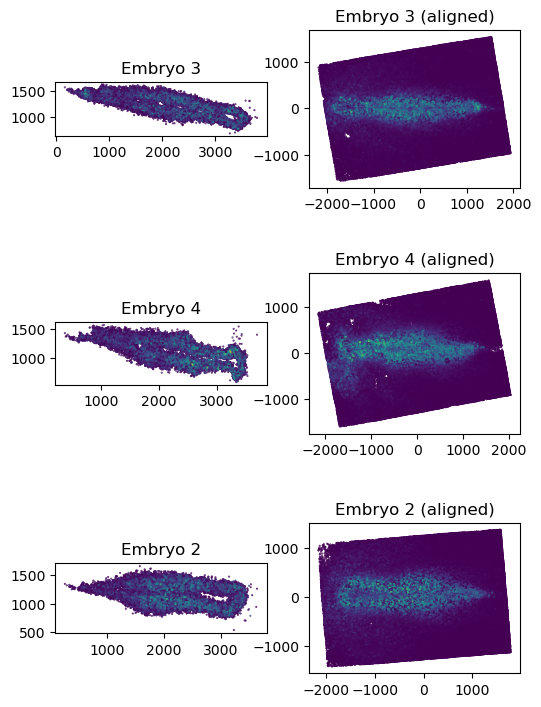

In [18]:
#plot the output
fig, ax = plt.subplots(no_embryos, 2, figsize=(6, no_embryos*3))

for idx, embryo in enumerate(all_cells['embryo'].unique()):
    temp = all_cells.loc[all_cells['embryo'] == embryo]
    top_T = temp[temp[midline_channel] > temp[midline_channel].quantile(0.9)]

    # top_T = top_T[top_T['is_epi_rd5'] ==1 ]

    ax[idx, 0].scatter(top_T['X'], top_T['Y'], c=top_T[midline_channel], cmap='viridis', s = 0.2)
    ax[idx, 0].set_title(f'Embryo {embryo}')
    #set ratio of x and y axis to be the same
    ax[idx, 0].set_aspect('equal', 'box')

    # Align major axis using the top 10% of cells
    aligned_points, rotation_matrix = align_major_axis_2d(np.array(top_T[['X', 'Y']]), 
                                                          np.array(temp[['X', 'Y']]))

    # Set alinged points centered at 0
    aligned_points = aligned_points - np.mean(aligned_points, axis=0)

    ax[idx, 1].scatter(aligned_points[:, 0], aligned_points[:, 1], c=all_cells.loc[all_cells['embryo'] == embryo,midline_channel], cmap='viridis', s = 0.2)
    ax[idx, 1].set_title(f'Embryo {embryo} (aligned)')
    ax[idx, 1].set_aspect('equal', 'box')

    #put back into main dataframe per embryo
    all_cells.loc[all_cells['embryo'] == embryo, 'Oriented_X'] = aligned_points[:, 0]
    all_cells.loc[all_cells['embryo'] == embryo, 'Oriented_Y'] = aligned_points[:, 1]


#### Smooth TBra signal prior to midline inference

Iteration round: 0
Iteration round: 1
Iteration round: 2
Iteration round: 3
Iteration round: 4
Iteration round: 0
Iteration round: 1
Iteration round: 2
Iteration round: 3
Iteration round: 4
Iteration round: 0
Iteration round: 1
Iteration round: 2
Iteration round: 3
Iteration round: 4


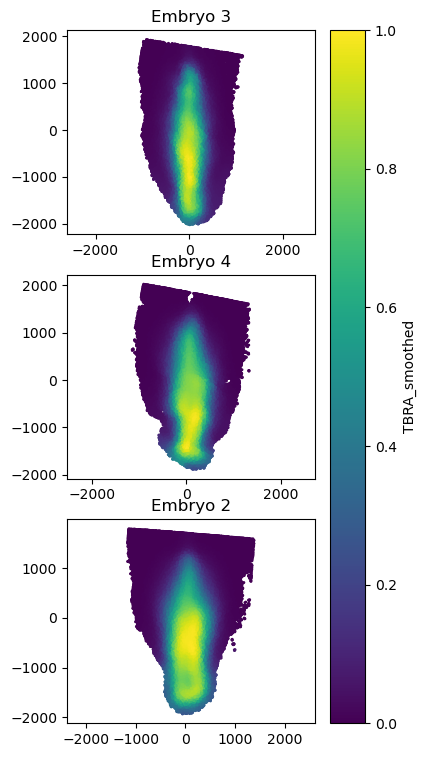

In [19]:
#loop through each embryo to smooth

for idx, embryo in enumerate(all_cells['embryo'].unique()):
    epi_nuc = all_cells[(epi_mask) & (all_cells['embryo'] == embryo)]

    #Store original index
    index = epi_nuc.index

    #reset index
    epi_nuc = epi_nuc.reset_index(drop=True)

    # Smooth signal in XYZ coordinates
    smoothed_props, smoothed_signal = smooth_signal_in_point_cloud(points = epi_nuc[['Z', 'X', 'Y']].values, 
                                                                     signal = epi_nuc[midline_channel], 
                                                                     iterations=5, # Number of iterations for smoothing
                                                                     radius=100) # Radius of smoothing in microns

    # Store smoothed signal in main dataframe
    all_cells.loc[index, midline_channel + '_smoothed'] = smoothed_signal

#Set new column name
smth_midline_channel = midline_channel + '_smoothed'

#Plot output
fig, ax = plt.subplots(no_embryos, 1, figsize=(4, no_embryos*3))
for idx, embryo in enumerate(all_cells['embryo'].unique()):

    #Select epiblast cells for each embryo
    epi_nuc = all_cells[(epi_mask) & (all_cells['embryo'] == embryo)]

    #Plot smoothed signal
    ax[idx].scatter(epi_nuc['Oriented_Y'], epi_nuc['Oriented_X'], c=epi_nuc[smth_midline_channel], s=1, cmap='viridis')
    ax[idx].set_title(f'Embryo {embryo}')
    ax[idx].axis('equal')
plt.colorbar(ax[0].scatter([], [], c=[], cmap='viridis', s=1), ax=ax, label= smth_midline_channel)
plt.show()

#### Find midline using smoothed midline channel

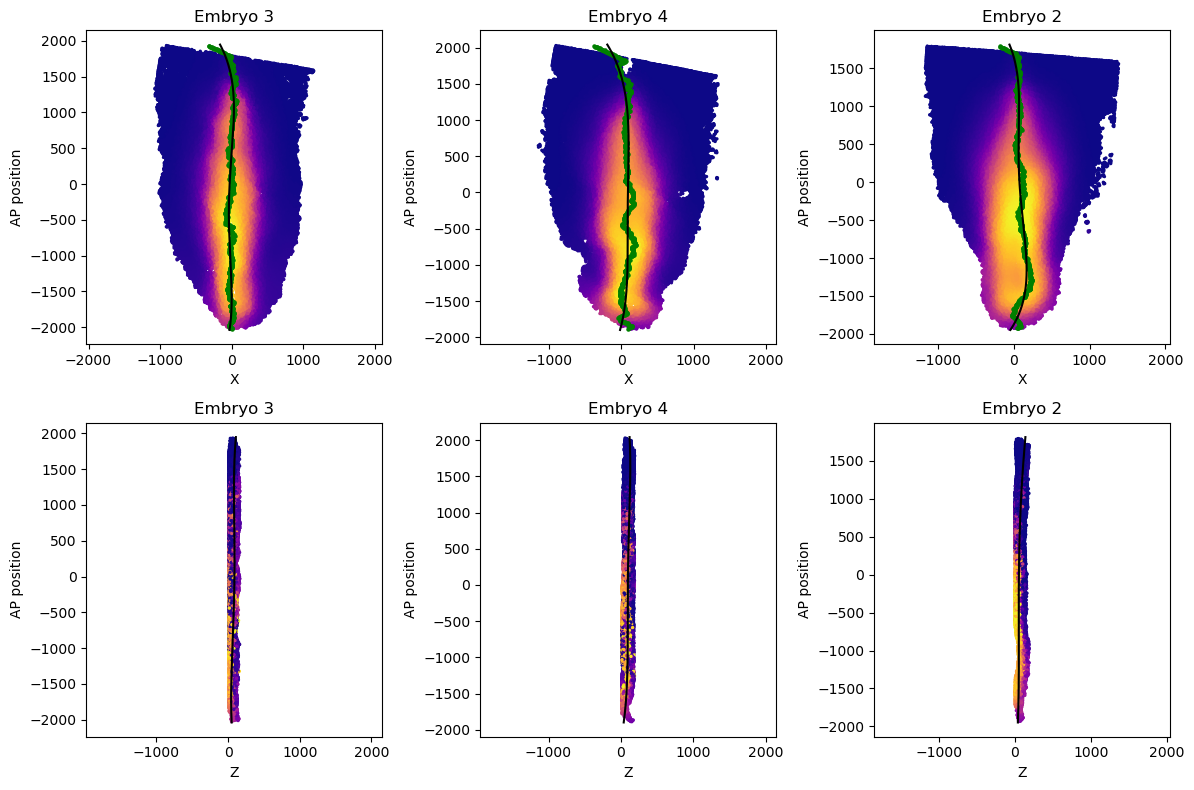

In [20]:
# #Set columns
x_col='Oriented_Y'
y_col='Oriented_X'
z_col='Z'

smoothed_line_all = []
original_midpoints = []

for embryo in all_cells['embryo'].unique():
    # Isolate epiblast cells per embryo
    epi_nuc = all_cells[(all_cells['embryo'] == embryo) & epi_mask]

    smoothed_line, centroids = find_midline(epi_nuc, 
                                      smth_midline_channel,
                                       x_col=x_col, 
                                       y_col=y_col, 
                                       z_col=z_col,
                                       percentile_threshold=0.8,
                                       lim_dist=10,
                                       window_size=10)
    smoothed_line['embryo'] = embryo
    smoothed_line_all.append(smoothed_line)

    centroids = pd.DataFrame(centroids, columns=[z_col, y_col, x_col])
    centroids['embryo'] = embryo
    original_midpoints.append(centroids)



#Plot original midline points and smoothed line in XY and XZ

fig, ax = plt.subplots(2, len(all_cells['embryo'].unique()), figsize=(12, 8))

for idx, embryo in enumerate(all_cells['embryo'].unique()):
    epi_nuc = all_cells[(all_cells['embryo'] == embryo) & epi_mask]
    smoothed_line = smoothed_line_all[idx]
    centroids = original_midpoints[idx]

    ax[0, idx].scatter(epi_nuc[x_col], epi_nuc[y_col], c=epi_nuc[smth_midline_channel], s=2, cmap='plasma')  
    ax[0, idx].scatter(centroids[x_col], centroids[y_col], c='g', s=5)
    ax[0, idx].plot(smoothed_line[x_col], smoothed_line[y_col], c='black')
    ax[0, idx].axis('equal')
    ax[0, idx].set_title(f'Embryo {embryo}')
    ax[0, idx].set_xlabel('X')
    ax[0, idx].set_ylabel('AP position')

    ax[1, idx].scatter(epi_nuc[z_col], epi_nuc[y_col], c=epi_nuc[smth_midline_channel], s=2, cmap='plasma')
    ax[1, idx].plot(smoothed_line[z_col], smoothed_line[y_col], c='black')
    ax[1, idx].axis('equal')
    ax[1, idx].set_title(f'Embryo {embryo}')
    ax[1, idx].set_xlabel('Z')
    ax[1, idx].set_ylabel('AP position')

plt.tight_layout()
plt.show()

smoothed_line_all = pd.concat(smoothed_line_all)
original_midpoints = pd.concat(original_midpoints)

#### Find L/R distance from midline along epithelial curve

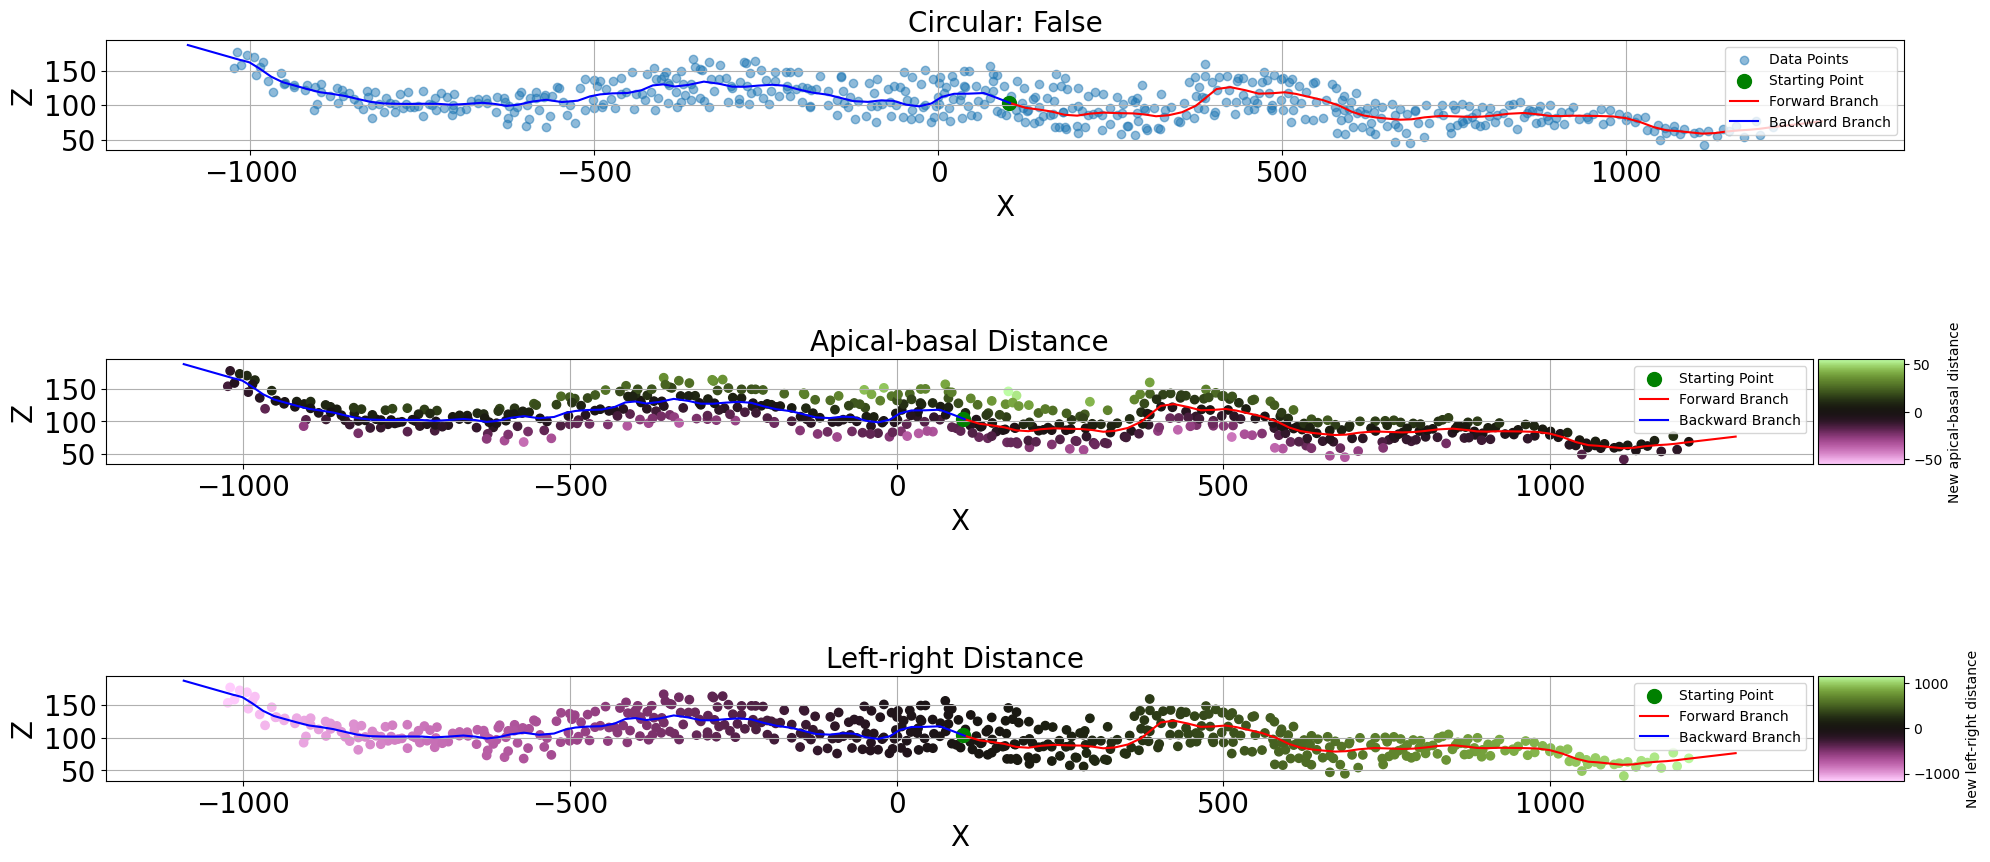

In [21]:
# Test on one slice to optimise parameters

#Set columns of used XYZ coordinates
x_col='Oriented_X'
y_col='Oriented_Y'
z_col='Z'

#Define the LR flattening class with parameters
LR_flattening_c = LR_flattening(
    h=20, # The distance considered for the local smoother
    step_size=20, # The step size for growing the line
    max_iter=100, # The maximum number of iterations in growing the line 
    tol=0.0001, # The tolerance in variation for stopping the growing
    start_point='custom', # We are providing a custom starting point
    z_col = z_col, # The column with the z-coordinates
    x_col = x_col, # The column with the x-coordinates
    y_col = y_col, # The column with the y-coordinates
    smooth_h=3 # The smoothing parameter for the line after fitting
    )

#Select embryo
embryo = 4
epi_nuc = all_cells[epi_mask & (all_cells['embryo'] == embryo)]

#remove inf values or NaNs
epi_nuc = epi_nuc.replace([np.inf, -np.inf], np.nan)
epi_nuc = epi_nuc.dropna(subset=[z_col, y_col])

#Select smoothed line
smoothed_line = smoothed_line_all[smoothed_line_all['embryo'] == embryo]
smoothed_line = smoothed_line.replace([np.inf, -np.inf], np.nan)
smoothed_line = smoothed_line.dropna(subset=[z_col, y_col])

#Use built in function to test slice
curve, distance_analysis = LR_flattening_c.test_slice(epi_nuc, 
                                          smoothed_line, 500,20)

In [22]:
# Flatten the whole embryo - faster version with optimized grouping and no sliding window

x_col='Oriented_X'
y_col='Oriented_Y'
z_col='Z'

#Record time per embryo
time_per_embryo = []

# Iterate over each unique embryo
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    # Initiate timer
    start_time = time.time()
    #
    print(f"Processing Embryo {embryo}")

    # Filter data for current embryo and select relevant columns
    epi_nuc = all_cells[(all_cells['embryo'] == embryo) & epi_mask]
    smoothed_line = smoothed_line_all[smoothed_line_all['embryo'] == embryo]

    # Assign unique IDs and track original index
    epi_nuc['original_index'] = epi_nuc.index
    epi_nuc['new_ID'] = np.arange(len(epi_nuc))
    unique_ids = np.sort(epi_nuc['new_ID'].unique())

    # Select key columns
    epi_nuc = epi_nuc[[z_col, y_col, x_col, 'new_ID', 'original_index']]

    # Define binning parameters
    start_point_iter = epi_nuc[x_col].min()
    end_point_iter = epi_nuc[x_col].max()

    step = 20 # don't make this too small as too few cells in each bin will cause issues
    iterations = np.arange(start_point_iter, end_point_iter + step, step)
    bin_edges = np.append(iterations, iterations[-1] + step)

    # Apply binning into discrete sections
    epi_nuc['section'] = np.digitize(epi_nuc[x_col], bins=bin_edges) - 1
    smoothed_line['section'] = np.digitize(smoothed_line[x_col], bins=bin_edges) - 1

    # Initialize accumulated data array
    accumulated_array = np.zeros((len(unique_ids), 3))

    # Group data by sections
    grouped_epi = epi_nuc.groupby('section')
    grouped_smoothed = smoothed_line.groupby('section')
    no_iterations = len(grouped_epi)

    # Initialize columns for analysis
    epi_nuc['AVLR'] = 0
    epi_nuc['New_Z'] = 0

    # Process each section
    for counter, (section, sub_slice) in enumerate(grouped_epi, start=1):
        print(f"Section {counter}/{no_iterations}", end='\r')

        # Skip if section not in smoothed data
        if section not in grouped_smoothed.groups:
            continue

        # Get smoothed line for the section
        sub_smoothed_line = grouped_smoothed.get_group(section)

        # Define the starting point for the line
        start_point = np.array([sub_smoothed_line[z_col].mean(), sub_smoothed_line[y_col].mean()])

        # Fit LR_flattening class
        LR_flattening_c = LR_flattening(
            h=40, # The distance considered for the local smoother
            step_size=30, # The step size for growing the line
            max_iter=100, # The maximum number of iterations in growing the line 
            tol=0.0001, # The tolerance in variation for stopping the growing
            start_point='custom', # We are providing a custom starting point
            z_col = z_col, # The column with the z-coordinates
            x_col = x_col, # The column with the x-coordinates
            y_col = y_col, # The column with the y-coordinates
            smooth_h=6 # The smoothing parameter for the line after 
            )
        
        # Find LR positions
        curve, distance_analysis = LR_flattening_c.fit_with_branches(sub_slice[[z_col, y_col]], start_point=start_point)

        # Accumulate results
        ids_in_section = sub_slice['new_ID'].values
        accumulated_array[ids_in_section, 0] += distance_analysis['Dist_from_midline'].values
        accumulated_array[ids_in_section, 1] += distance_analysis['intersection_distance'].values
        accumulated_array[ids_in_section, 2] += 1

    # Finalize analysis columns
    epi_nuc['AVLR'] = accumulated_array[:, 0] / accumulated_array[:, 2]
    epi_nuc['New_Z'] = accumulated_array[:, 1] / accumulated_array[:, 2]

    # Map results back to original dataframe
    all_cells.loc[epi_nuc['original_index'], 'AVLR'] = epi_nuc['AVLR'].values
    all_cells.loc[epi_nuc['original_index'], 'New_Z'] = epi_nuc['New_Z'].values

    # Record time
    time_per_embryo.append(time.time() - start_time)


print(f"Average time per embryo: {np.mean(time_per_embryo):.2f} seconds")




Processing Embryo 3
Processing Embryo 4
Processing Embryo 2
Average time per embryo: 127.21 seconds


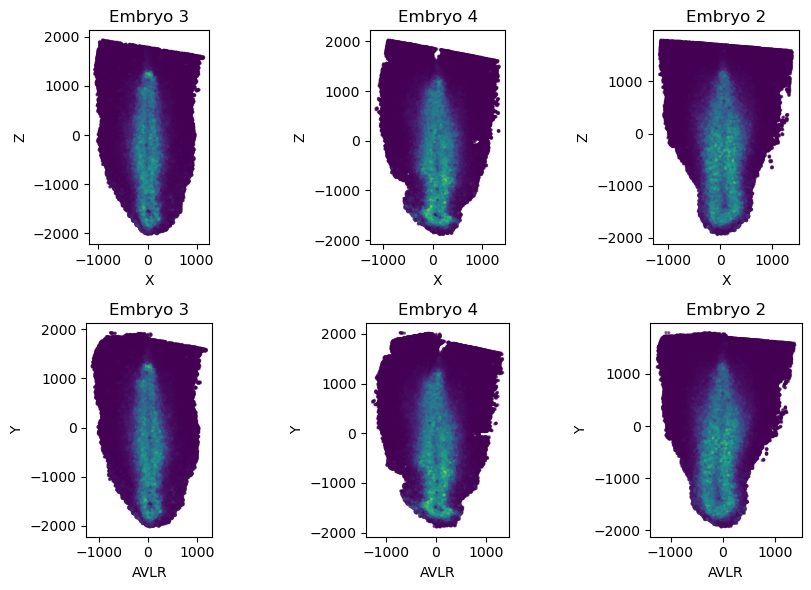

In [25]:
# Create plots
fig, ax = plt.subplots(2, no_embryos, figsize=(3 * no_embryos, 6))

# Visualize results
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    temp = all_cells[(all_cells['embryo'] == embryo) & epi_mask]

    ax[0, idx].scatter(temp['Oriented_Y'], temp['Oriented_X'], c=temp[midline_channel], alpha=0.5, s=2)
    ax[0, idx].set_title(f'Embryo {embryo}')
    ax[0, idx].set_xlabel('X')
    ax[0, idx].set_ylabel('Z')
    ax[0, idx].set_aspect('equal', adjustable='box')

    temp = all_cells[all_cells['embryo'] == embryo]
    ax[1, idx].scatter(temp['AVLR'], temp[x_col], c=temp[midline_channel], alpha=0.5, s=2)
    ax[1, idx].set_title(f'Embryo {embryo}')
    ax[1, idx].set_xlabel('AVLR')
    ax[1, idx].set_ylabel('Y')
    ax[1, idx].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## 2. Normalise Embryos together

#### Find Node and end of PS

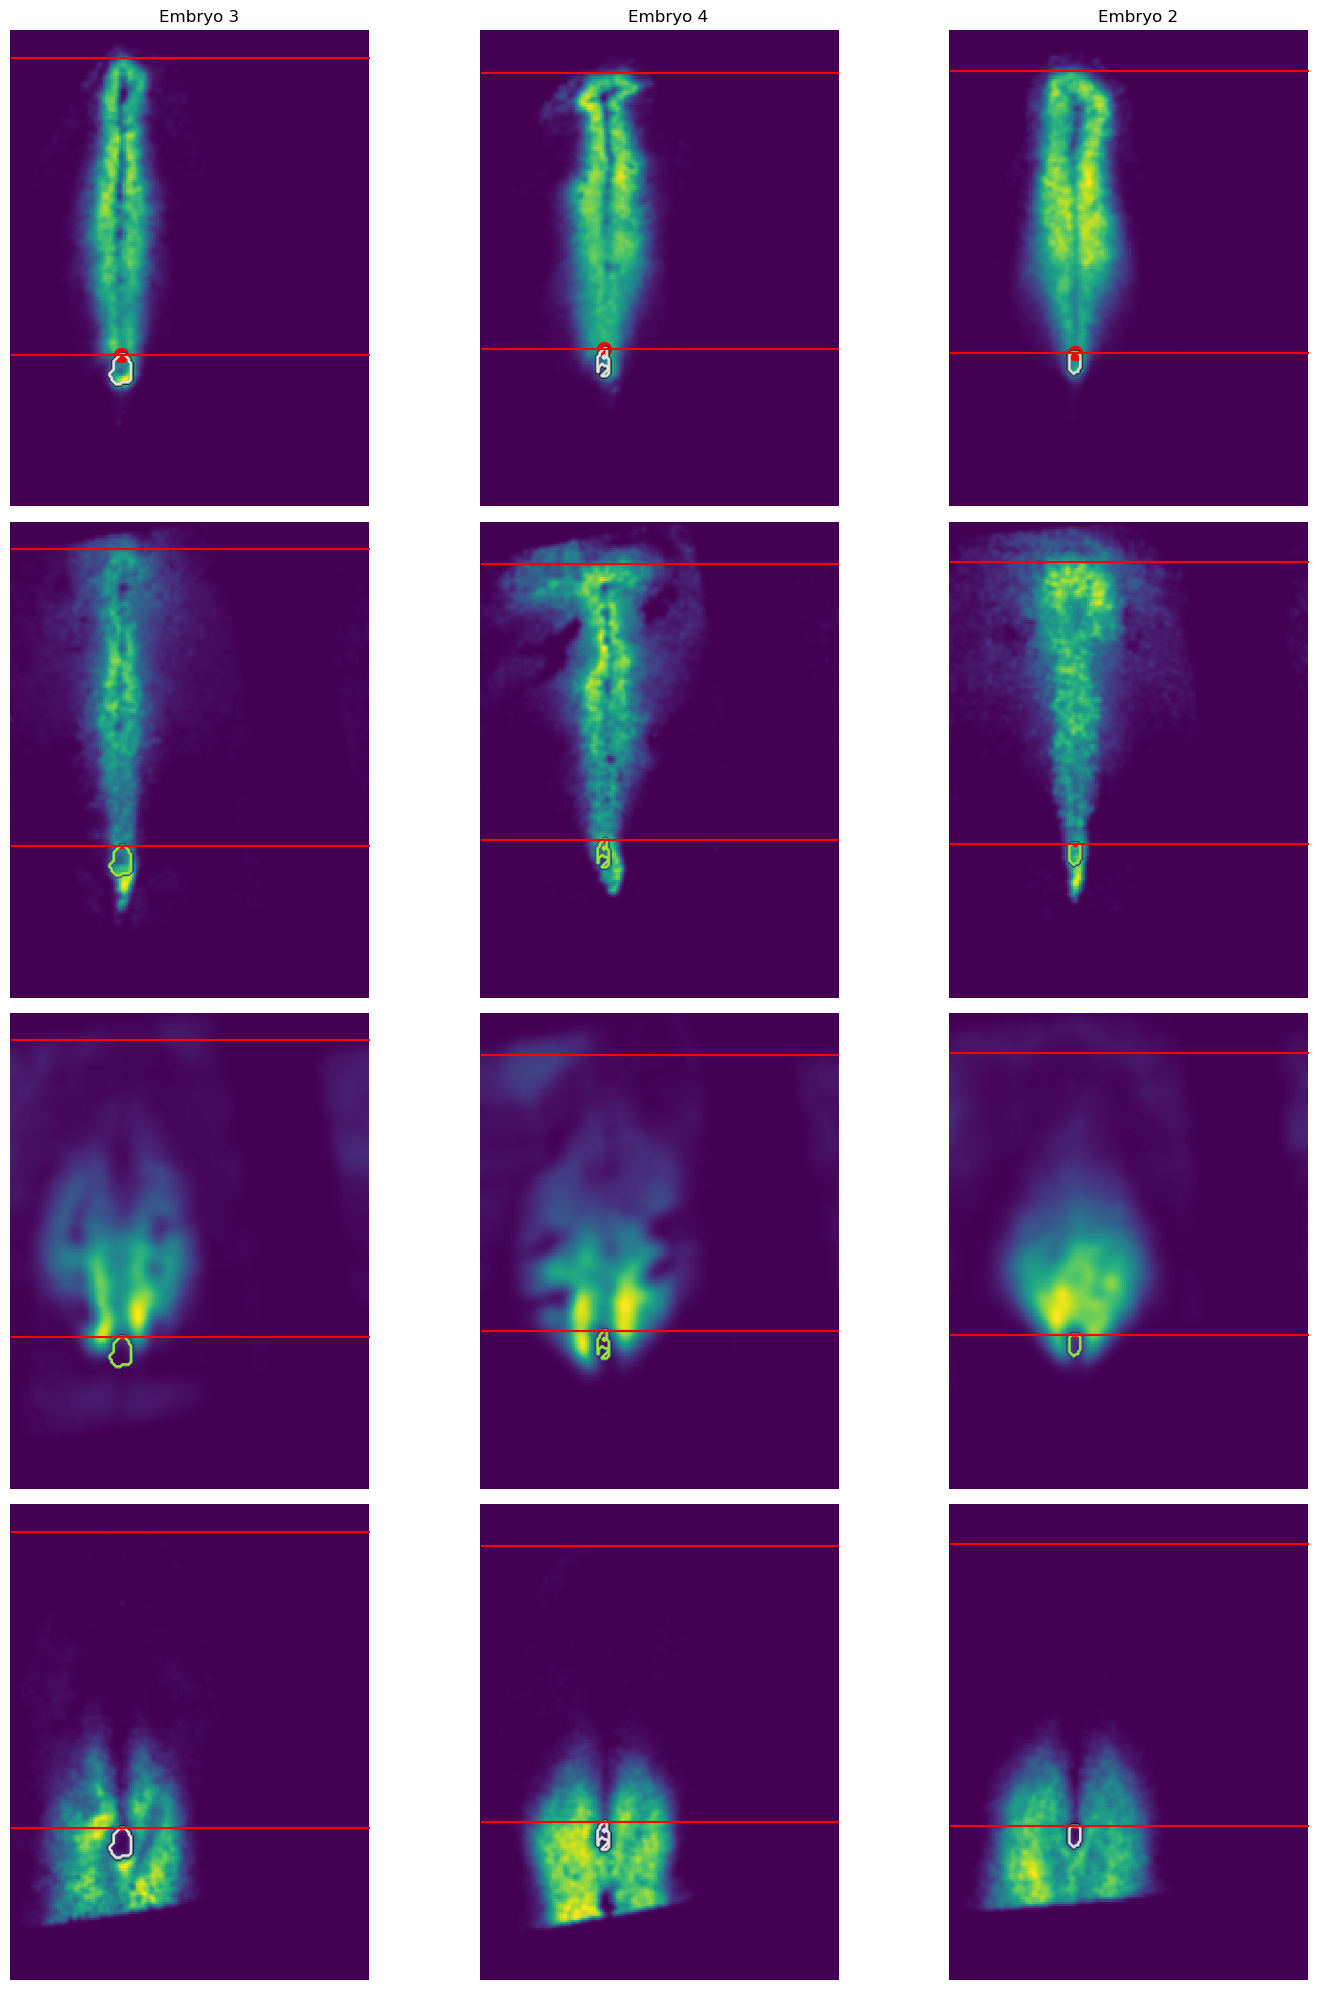

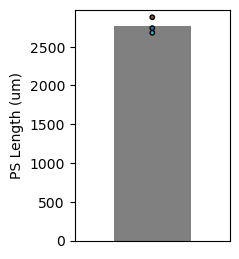

In [29]:
# Chick specific automatic finding of start of notochord and node streak border


#Find end of PS and the start of the notochord
scale = 20
PS_points = []
fig, axes = plt.subplots( 4, len(all_cells['embryo'].unique()), figsize=(15, 20))

#Set columns for XY coordinates
x_col = 'Oriented_X'
y_col = 'Oriented_Y'

for idx, embryo in enumerate(all_cells['embryo'].unique()):

    #Select epiblast cells for each embryo
    epi_nuc = all_cells.loc[(all_cells['embryo'] == embryo) & epi_mask]

    #Select non-epiblast cells for each embryo
    non_epi_nuc = all_cells.loc[(all_cells['embryo'] == embryo) & ~epi_mask]
    
    min_xpoint = min(epi_nuc[x_col].min(), non_epi_nuc[x_col].min())

    #Select top 50% of cells for each marker
    top_T_epi = epi_nuc[epi_nuc['TBRA'] > epi_nuc['TBRA'].quantile(0.5)]
    top_Sox2_epi = epi_nuc[epi_nuc['SOX2'] > epi_nuc['SOX2'].quantile(0.5)]
    top_Msgn1_meso = non_epi_nuc[non_epi_nuc['MSGN1'] > non_epi_nuc['MSGN1'].quantile(0.5)]
    top_T_meso = non_epi_nuc[non_epi_nuc['TBRA'] > non_epi_nuc['TBRA'].quantile(0.5)]

    # Create images for each marker
    img_shape = (int( (all_cells[x_col].max() - all_cells[x_col].min())*1.1 / scale), 
                 int((all_cells[y_col].max() - all_cells[y_col].min())*1.1 / scale))

    # Create images for each marker
    img_T_meso = np.zeros(img_shape).astype('float')
    img_T_epi = np.zeros(img_shape).astype('float')
    img_Msgn1_meso = np.zeros(img_shape).astype('float')
    img_sox2_epi = np.zeros(img_shape).astype('float')

    # Create count images for each marker
    count_T_epi = np.zeros(img_shape)
    count_T_meso = np.zeros(img_shape)
    count_Msgn1_meso = np.zeros(img_shape)
    count_sox2_epi = np.zeros(img_shape)

    # Bin the data into the images
    Te_x_bins = ((top_T_epi[x_col] - min_xpoint) / scale).astype(int)
    Te_y_bins = ((top_T_epi[y_col] - epi_nuc[y_col].min()) / scale).astype(int)

    Tm_x_bins = ((top_T_meso[x_col] - min_xpoint) / scale).astype(int)
    Tm_y_bins = ((top_T_meso[y_col] - epi_nuc[y_col].min()) / scale).astype(int)

    Mm_x_bins = ((top_Msgn1_meso[x_col] - min_xpoint) / scale).astype(int)
    Mm_y_bins = ((top_Msgn1_meso[y_col] - epi_nuc[y_col].min()) / scale).astype(int)

    Se_x_bins = ((top_Sox2_epi[x_col] - min_xpoint) / scale).astype(int)
    Se_y_bins = ((top_Sox2_epi[y_col] - epi_nuc[y_col].min()) / scale).astype(int)

    # Add the data to the images in bins
    np.add.at(img_T_epi, (Te_x_bins, Te_y_bins),  top_T_epi['TBRA'])
    np.add.at(count_T_epi, (Te_x_bins, Te_y_bins), 1)

    np.add.at(img_T_meso, (Tm_x_bins, Tm_y_bins), top_T_meso['TBRA'])
    np.add.at(count_T_meso, (Tm_x_bins, Tm_y_bins), 1)

    np.add.at(img_Msgn1_meso, (Mm_x_bins, Mm_y_bins), top_Msgn1_meso['MSGN1'])
    np.add.at(count_Msgn1_meso, (Mm_x_bins, Mm_y_bins), 1)

    np.add.at(img_sox2_epi, (Se_x_bins, Se_y_bins), top_Sox2_epi['SOX2'])
    np.add.at(count_sox2_epi, (Se_x_bins, Se_y_bins), 1)

    # Exclude bins below lowest 5th percentile
    img_T_epi += np.percentile(img_T_epi[img_T_epi > 0], 0.05)
    img_T_meso += np.percentile(img_T_meso[img_T_meso > 0], 0.05)
    img_Msgn1_meso += np.percentile(img_Msgn1_meso[img_Msgn1_meso > 0], 0.05)
    img_sox2_epi += np.percentile(img_sox2_epi[img_sox2_epi > 0], 0.05)

    # Normalise the images by the count
    img_T_epi = img_T_epi / (count_T_epi+1)
    img_T_meso = img_T_meso / (count_T_meso+1)
    img_Msgn1_meso = img_Msgn1_meso / (count_Msgn1_meso+1)
    img_sox2_epi = img_sox2_epi / (count_sox2_epi+1)
    
    # Set the images
    img_Tepi = img_T_epi
    img_Tmeso = img_T_meso
    img_Msgn1meso = img_Msgn1_meso
    img_Sox2epi = img_sox2_epi

    # Smooth signal
    img_Tepi = ski.filters.gaussian(img_Tepi, 1)
    img_Tmeso = ski.filters.gaussian(img_Tmeso, 1)
    img_Sox2epi = ski.filters.gaussian(img_Sox2epi, 1)
    img_Msgn1meso = ski.filters.gaussian(img_Msgn1meso, 3) #extra smoothing for mesoderm 

    # Otsu thresholding
    thresh_Tepi = ski.filters.threshold_otsu(img_Tepi)
    mask_Tepi = img_Tepi > thresh_Tepi

    thresh_Tmeso = ski.filters.threshold_otsu(img_Tmeso)
    mask_Tmeso = img_Tmeso > thresh_Tmeso

    thresh_Msgn1meso = ski.filters.threshold_otsu(img_Msgn1meso)
    mask_Msgn1meso = img_Msgn1meso > thresh_Msgn1meso

    thresh_Sox2epi = ski.filters.threshold_otsu(img_Sox2epi)
    mask_Sox2epi = img_Sox2epi > thresh_Sox2epi

    #Find noto chord by Sox2-epi negative and Msgn1-meso negative but T-meso positive
    noto = np.logical_and(np.logical_and(~mask_Sox2epi, ~mask_Msgn1meso), mask_Tmeso)

    #label notochord masks
    noto = ski.measure.label(noto)

    #Find most anterior notochord mask
    props = pd.DataFrame(ski.measure.regionprops_table(noto, properties=('label', 'centroid', 'bbox')))

    noto_region = props[props['centroid-0'] == props['centroid-0'].max()]

    #Node/Streak border point - anterior bbox point
    NSB_point = (noto_region['bbox-0'], noto_region['centroid-1'])

    #set non noto to nan for plotting
    noto_nan = np.copy(noto)
    noto_nan[noto_nan == 0] = 0

    #Set non-noto region to nan
    noto_nan[~(noto_nan == noto_region['label'].values)] = 0


    ys, xs = np.indices(mask_Tepi.shape)
    min_PSpoint = np.min(ys[mask_Tepi])
    max_PSxpoint = noto_region['bbox-0'].values[0]


    min_xpoint_resc = (min_PSpoint * scale) + min_xpoint
    max_xpoint_resc = (max_PSxpoint * scale) + min_xpoint

    PS_points.append({'embryo': embryo, 'min_x': min_xpoint_resc, 'max_x': max_xpoint_resc})

    PS_points_df = pd.DataFrame(PS_points)
    all_cells.loc[(all_cells['embryo'] == embryo) & epi_mask, 'AP_noto'] = (all_cells.loc[(all_cells['embryo'] == embryo) & (epi_mask), x_col] - max_xpoint_resc)

    all_cells.loc[(all_cells['embryo'] == embryo) & epi_mask, 'Rel_AP_position'] = (all_cells.loc[(all_cells['embryo'] == embryo) & (epi_mask), x_col] - min_xpoint_resc) / (max_xpoint_resc - min_xpoint_resc)

    #plot each image
    axes[0,idx].imshow(img_Tepi, cmap='viridis', interpolation='none')
    axes[0,idx].set_title(f'Embryo {embryo}')
    axes[0,idx].axis('off') 
    axes[0,idx].contour(noto_nan, interpolation='none', cmap = 'gray')
    #plot contour around
    axes[0,idx].scatter(NSB_point[1], NSB_point[0], c='r', s=100)
    axes[0,idx].hlines(min_PSpoint, 0, mask_Tepi.shape[1], color='r')
    axes[0,idx].hlines(max_PSxpoint, 0, mask_Tepi.shape[1], color='r')


    axes[1,idx].imshow(img_Tmeso, cmap='viridis', interpolation='none')
    axes[1,idx].axis('off')
    axes[1,idx].scatter(NSB_point[1], NSB_point[0], c='r', s=10)
    axes[1,idx].contour(noto_nan, c='white', interpolation='none')
    axes[1,idx].hlines(min_PSpoint, 0, mask_Tmeso.shape[1], color='r')
    axes[1,idx].hlines(max_PSxpoint, 0, mask_Tmeso.shape[1], color='r')

    axes[2,idx].imshow(img_Msgn1meso, cmap='viridis', interpolation='none')
    axes[2,idx].axis('off')
    axes[2,idx].scatter(NSB_point[1], NSB_point[0], c='r', s=10)
    axes[2,idx].contour(noto_nan, c='white', interpolation='none')
    axes[2,idx].hlines(min_PSpoint, 0, mask_Msgn1meso.shape[1], color='r')
    axes[2,idx].hlines(max_PSxpoint, 0, mask_Msgn1meso.shape[1], color='r')
    axes[3,idx].imshow(img_Sox2epi, cmap='viridis', interpolation='none')
    axes[3,idx].axis('off')
    axes[3,idx].scatter(NSB_point[1], NSB_point[0], c='r', s=10)
    axes[3,idx].contour(noto_nan, interpolation='none', cmap = 'gray')
    axes[3,idx].hlines(min_PSpoint, 0, mask_Sox2epi.shape[1], color='r')
    axes[3,idx].hlines(max_PSxpoint, 0, mask_Sox2epi.shape[1], color='r')

plt.tight_layout()

PS_points_df = pd.DataFrame(PS_points)

#Flip AP so anterior is down

all_cells['Rel_AP_position'] = (all_cells['Rel_AP_position']*-1) + 1
all_cells['AP_noto'] = (all_cells['AP_noto']*-1) + 1

#average the length of the PS for each embryo
PS_points_df['PS_length'] = PS_points_df['max_x'] - PS_points_df['min_x']
mean_length = PS_points_df['PS_length'].mean()
mean_length = mean_length 

plt.figure(figsize=(2,3))
plt.bar(0, mean_length, color='grey', label='Mean Length', width=0.5)
plt.scatter(np.zeros(len(PS_points_df['PS_length'])), PS_points_df['PS_length'], c = PS_points_df['embryo'], cmap='tab10', s =10,
            facecolors='none', edgecolors='black')
plt.ylim(0, max(PS_points_df['PS_length']) + 100)
plt.ylabel('PS Length (um)')
plt.xlim(-0.5, 0.5)
plt.xticks([])

# Set the scaled AP position
all_cells['Scaled_Rel_AP_position'] = all_cells['Rel_AP_position'] * mean_length 



#### Find relative positions from midline to epithelia edge, then scale to average width per AP position

Embryo 3
Embryo 4
Embryo 2


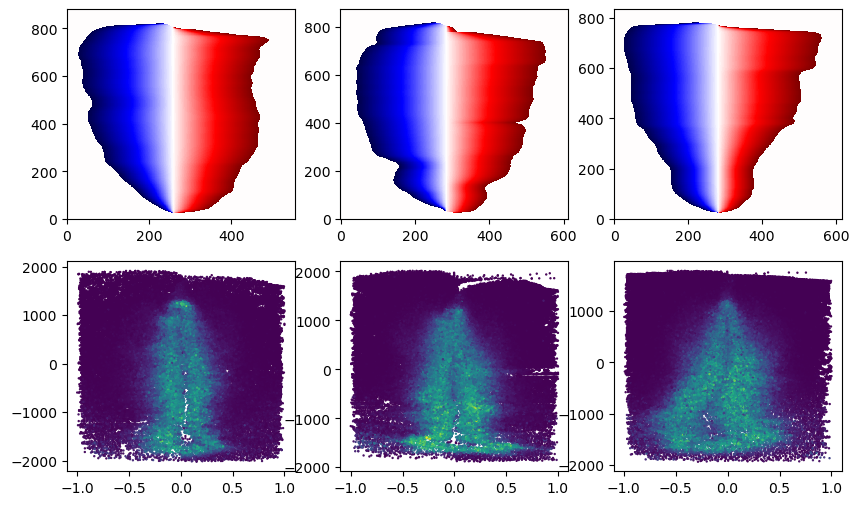

In [ ]:
# Find the relative map

#Find relaitve position of each cell from the midline to the edge per AP positions
# Chick epiblast inference isn't perfect, so we'll smooth the edges location a bit

fig, ax = plt.subplots(2, len(all_cells['embryo'].unique()), figsize=(10, 6))


x_col = 'Oriented_X'
y_col = 'Oriented_Y'
z_col = 'Z'


downscaler = 5
smoother = 10
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    print(f"Embryo {embryo}")
    epi_nuc = all_cells[(all_cells['embryo'] == embryo) & epi_mask]
    indexes = epi_nuc.index
    epi_nuc['original_index'] = indexes
    #remove cells with no neighbors

    # Normalize AVLR and Oriented_X to positive values to fill in image
    midline = epi_nuc['AVLR'].min()
    epi_nuc['AVLR_pos'] = epi_nuc['AVLR'] - midline
    epi_nuc[x_col+'_pos'] = epi_nuc[x_col] - epi_nuc[x_col].min()

    # Remove NaNs together to avoid mismatched lengths
    epi_nuc_clean = epi_nuc.dropna(subset=['AVLR_pos', x_col+'_pos'])

    # Convert to image coordinates (add 50 pixel buffer)

    pix_buffer = 30
    LR_coords = ((epi_nuc_clean['AVLR_pos'] / downscaler).astype(int).values + pix_buffer).astype(int)
    X_coords = ((epi_nuc_clean[x_col+'_pos'] / downscaler).astype(int).values+ pix_buffer).astype(int)

    # Create a blank image
    img = np.zeros((LR_coords.max() + int(pix_buffer*2), X_coords.max() + int(pix_buffer*2)))

    # Fill in the image for outline mask
    img[LR_coords, X_coords] = 1

    # Fill in small gaps in the mask
    img_filled = ski.morphology.binary_closing(img, ski.morphology.disk(3))

    #Smooth the img then li threshold to find outline of epiblast
    img_filled = ski.filters.gaussian(img_filled, sigma = smoother, mode = 'reflect')
    img_filled = img_filled > ski.filters.threshold_li(img_filled)

    # Midline converted into image coordinates
    midline_img = (abs(midline) / downscaler) + pix_buffer

    # Initialize the relative map and absolute map
    rel_map = np.zeros_like(img_filled, dtype=float)
    abs_map = np.zeros_like(img_filled, dtype=float)

    # Loop through each X column in image
    for x in range(img_filled.shape[1]):
        column = img_filled[:, x]
        
        # Skip empty columns
        if column.sum() == 0:
            continue
        
        # Top and bottom outlines
        top = np.argmax(column)
        bottom = len(column) - np.argmax(column[::-1]) - 1

        # Relative positions  and abs (in downscaled pixels) from midline
        for y in range(top, bottom + 1):
            if y < midline_img:
                rel_map[y, x] = (y - midline_img) / (midline_img - top) if midline_img != top else 0
                abs_map[y, x] = (y - midline_img)
            else:
                rel_map[y, x] = (y - midline_img) / (bottom - midline_img) if bottom != midline_img else 0
                abs_map[y, x] = (y - midline_img)

    # Display the relative map
    ax[0, idx].imshow(rel_map.T, cmap='seismic', aspect='auto', vmin=-1, vmax=1, interpolation='none',
                      origin='lower')

    rel_map[~img_filled] = np.nan

    # Resize rel_map by a factor of the downscaler
    rel_map = resize(rel_map, (rel_map.shape[0] * downscaler, rel_map.shape[1] * downscaler), order=0, anti_aliasing=False)

    # Resize abs_map by a factor of the downscaler
    abs_map = resize(abs_map, (abs_map.shape[0] * downscaler, abs_map.shape[1] * downscaler), order=0, anti_aliasing=False)* downscaler

    # Convert positions to the resized image scale
    AVLR_scaled = (epi_nuc_clean['AVLR_pos']).astype(int).values + pix_buffer*downscaler
    X_scaled = (epi_nuc_clean[x_col+'_pos']).astype(int).values + pix_buffer*downscaler

    #Store indexes of points outside the image
    outside_idx = np.where((AVLR_scaled > rel_map.shape[0] - 1) | (X_scaled > rel_map.shape[1] - 1))[0]

    # Ensure coordinates don’t go out of bounds
    AVLR_scaled = np.clip(AVLR_scaled, 0, rel_map.shape[0] - 1)
    X_scaled = np.clip(X_scaled, 0, rel_map.shape[1] - 1)

    # Assign relative map values back into epi_nuc
    epi_nuc.loc[epi_nuc_clean.index, 'Rel_LR_position'] = rel_map[AVLR_scaled, X_scaled]

    #set points outside the image to nan
    epi_nuc.loc[epi_nuc_clean.index[outside_idx], 'Rel_position'] = np.nan

    # Display the relative map
    ax[1, idx].scatter(epi_nuc['Rel_LR_position'], epi_nuc[x_col], c = epi_nuc['TBRA'],s=0.5)

    # Add back into full df
    all_cells.loc[(all_cells['embryo'] == embryo) & epi_mask, 'Rel_LR_position'] = epi_nuc['Rel_LR_position']
    



#### Noralised distance from midline to edge

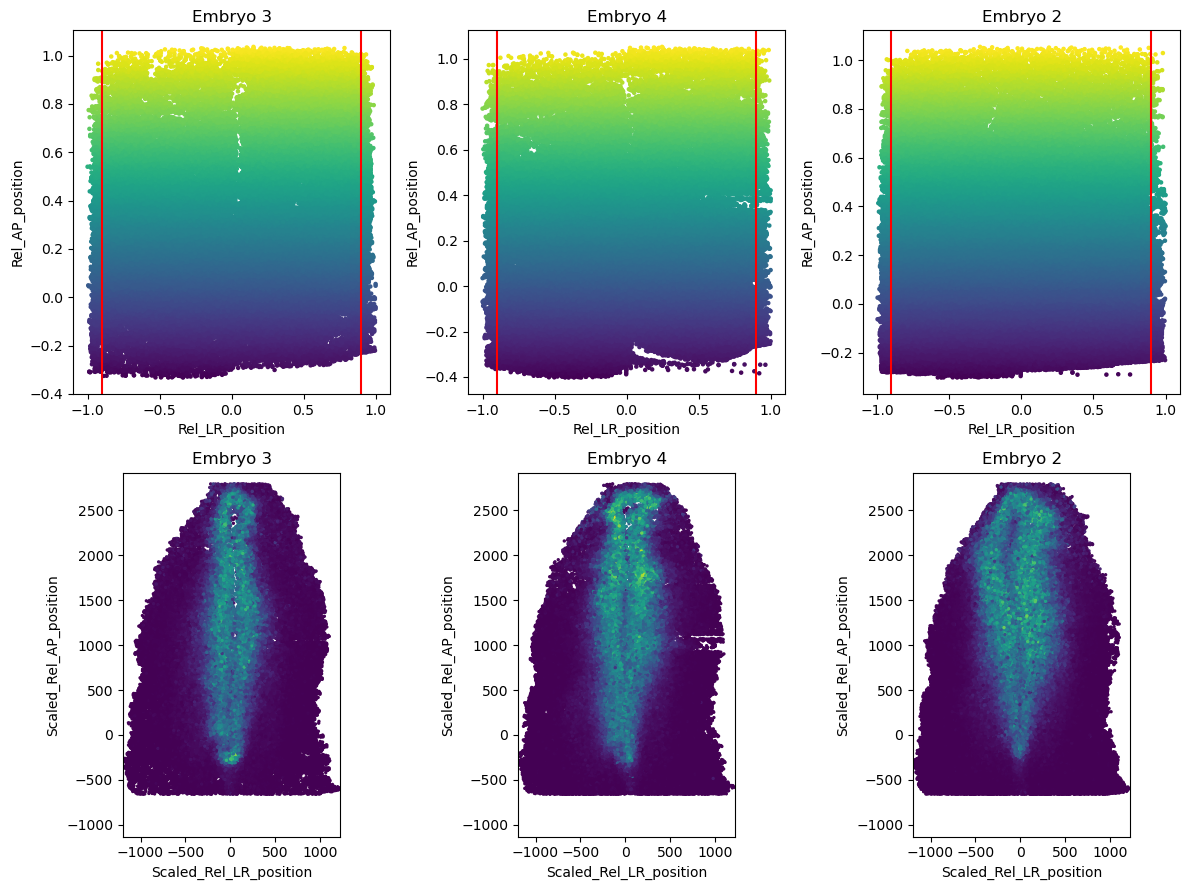

In [35]:
#Choose the column to use for the AP axis
y_col = 'Rel_AP_position'

# Left-right limits
LR_limits = 0.9

# Binning
binsize = 0.01
bins = np.arange(all_cells[y_col].min(), all_cells[y_col].max(), binsize)

all_cells['binned'] = np.digitize(all_cells[y_col], bins)

l_means, r_means = compute_mean_edge_position(all_cells, 
                                              epi_mask,
                                              embryo_id = 'embryo', 
                                              LR_col = 'AVLR',
                                               LR_limit = LR_limits)


# scale left and right values to the mean values per bin
all_cells.loc[(all_cells['Rel_LR_position'] > 0) & epi_mask, 'mean_Abss'] = all_cells.loc[(all_cells['Rel_LR_position'] > 0) & epi_mask, 'binned'].map(l_means['mean_Abss'])
all_cells.loc[(all_cells['Rel_LR_position'] < 0) & epi_mask, 'mean_Abss'] = all_cells.loc[(all_cells['Rel_LR_position'] < 0) & epi_mask, 'binned'].map(r_means['mean_Abss'])

# Scale the values by the threshold
all_cells['Scaled_Rel_LR_position'] = all_cells['mean_Abss'] * abs(all_cells['Rel_LR_position'])

#Divide by the threshold to account for loss of distance
all_cells['Scaled_Rel_LR_position'] = all_cells['Scaled_Rel_LR_position'] / LR_limits


fig, ax = plt.subplots(2, len(all_cells['embryo'].unique()), figsize=(12, 9))
for idx, embryo in enumerate(all_cells['embryo'].unique()):
    temp = all_cells[(all_cells['embryo'] == embryo) & epi_mask]
    ax[0,idx].scatter(temp['Rel_LR_position'], temp[y_col], c=temp['binned'], s=5)
    ax[0,idx].set_title(f'Embryo {embryo}') 
    ax[0,idx].set_xlabel('Rel_LR_position')
    ax[0,idx].set_ylabel('Rel_AP_position')

    #show thresholda
    ax[0,idx].axvline(x=LR_limits, color='r')
    ax[0,idx].axvline(x=-LR_limits, color='r')

    ax[1, idx].scatter(temp['Scaled_Rel_LR_position'], temp['Scaled_Rel_AP_position'], c=temp['TBRA'], s=2)
    ax[1, idx].set_title(f'Embryo {embryo}')
    ax[1, idx].set_xlabel('Scaled_Rel_LR_position')
    ax[1, idx].set_ylabel('Scaled_Rel_AP_position')
    ax[1, idx].set_aspect('equal')

    #enforce limits from whole dataset
    xlim = all_cells['Scaled_Rel_LR_position'].min(), all_cells['Scaled_Rel_LR_position'].max()
    ylim = all_cells['Scaled_Rel_AP_position'].min(), all_cells['Scaled_Rel_AP_position'].max()

    ax[1, idx].set_xlim(xlim)
    ax[1, idx].set_ylim(ylim)
    
plt.tight_layout()
plt.show()

## Example plots for relative and real space epiblast maps

#### Setting manual thresholds and isolating Sox2/Tbra positive cells

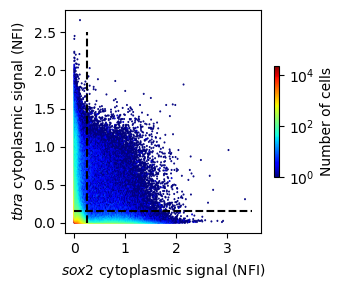

In [38]:
Sox2_thresh = 0.24
TBRA_Thresh = 0.15

all_cells['TBRA_SOX2_pos'] = (all_cells['TBRA'] > TBRA_Thresh) & (all_cells['SOX2'] > Sox2_thresh)    


#Plot hexbin for all embryos and Sox2/TBRA
fig, ax = plt.subplots(1,1, figsize=(3.5,3))


#set 0 to empty
ax.hexbin(all_cells['SOX2'], all_cells['TBRA'], gridsize=300, cmap='jet', norm=LogNorm() )

ax.set_xlabel('$sox2$ cytoplasmic signal (NFI)')
ax.set_ylabel('$tbra$ cytoplasmic signal (NFI)')

#plot colorbar
cb = plt.colorbar(ax.collections[0], ax=ax, label='Number of cells', shrink = 0.5)

ax.hlines(TBRA_Thresh, 0, 3.5, color='black', linestyle='--')
ax.vlines(Sox2_thresh, 0, 2.5, color='black', linestyle='--')

plt.tight_layout()


#### Plot average density of Sox2/Tbra cells and each channel in scaled normalised space

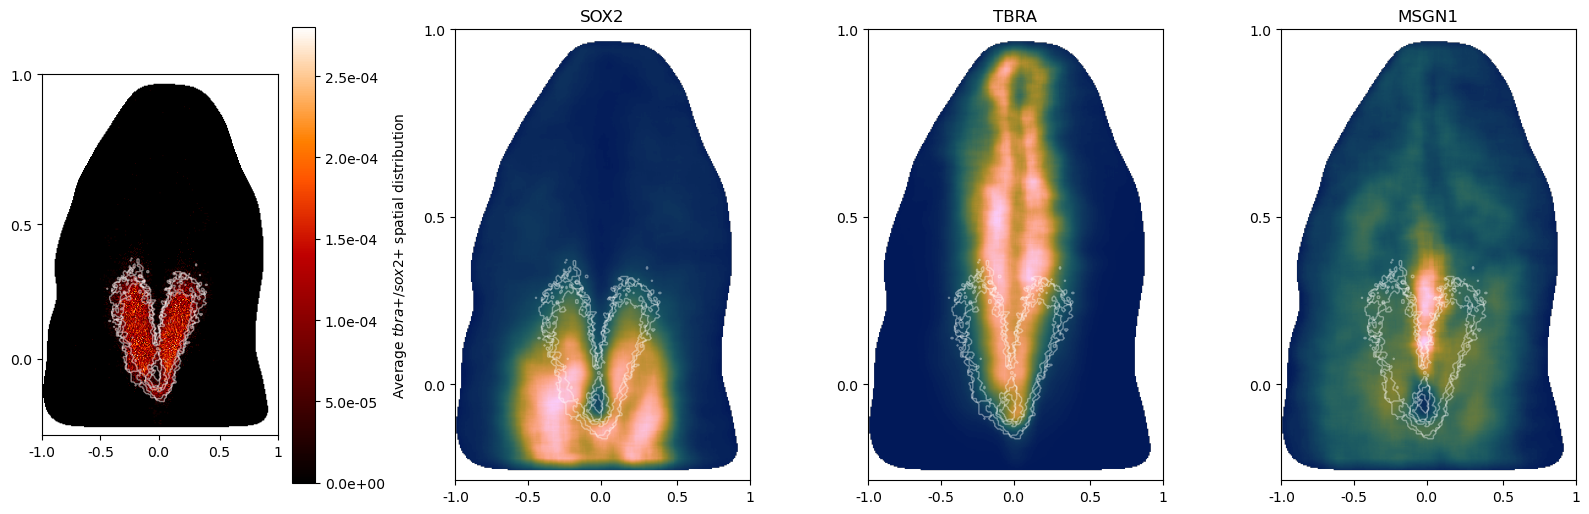

In [39]:
# Filter epiblast cells
epi_nuc = all_cells[epi_mask]

# Scale position coordinates
ant_limit = abs(epi_nuc['Scaled_Rel_AP_position'].min())
LR_mid = abs(epi_nuc['Scaled_Rel_LR_position'].min())

#Store the length scales
PS_length = epi_nuc['Scaled_Rel_AP_position'].max()
LR_length = epi_nuc['Scaled_Rel_LR_position'].max() + abs(epi_nuc['Scaled_Rel_LR_position'].min())

epi_nuc['Scaled_Rel_AP_position'] -= epi_nuc['Scaled_Rel_AP_position'].min()
epi_nuc['Scaled_Rel_LR_position'] -= epi_nuc['Scaled_Rel_LR_position'].min()

# Configuration settings
x_col, y_col = 'Scaled_Rel_LR_position', 'Scaled_Rel_AP_position'
channels = ['SOX2', 'TBRA', 'MSGN1']
embryos = [1, 2, 3, 4]
scale, pad, ant_cut = 10, 20, 35
img_shape = (int(epi_nuc[x_col].max() / scale), int(epi_nuc[y_col].max() / scale))
LR_mid, ant_limit = int(LR_mid / scale), (ant_limit // scale) - ant_cut
post_lim = int(epi_nuc[y_col].max() / scale) - ant_cut
APmid = post_lim - ant_limit

# Initialize storage
avg_imgs = {channel: np.zeros(img_shape) for channel in channels}
counts = {channel: np.zeros(img_shape) for channel in channels}
all_counts = np.zeros(img_shape)
SOX2TBRAcounts = np.zeros(img_shape)
SOX2TBRA_outlines = []
footprint = np.ones((12, 12))

# Process each embryo
for embryo in embryos:
    temp = epi_nuc[epi_nuc['embryo'] == embryo].copy().dropna(subset=[x_col, y_col] + channels)

    # Count SOX2/TBRA positive cells
    temp_st = temp[temp['TBRA_SOX2_pos']]
    x_bins, y_bins = (temp_st[x_col] / scale).astype(int), (temp_st[y_col] / scale).astype(int)
    count = np.zeros(img_shape)
    np.add.at(count, (x_bins-1, y_bins-1), 1)
    valid = count > 0
    count[valid] /= len(temp_st)

    # Smooth and outline
    pos_region = ski.filters.gaussian(count > 0, sigma=1) > 0.5
    SOX2TBRA_outlines.append(pos_region)
    SOX2TBRAcounts += count

    # Bin and average channel data
    x_bins, y_bins = (temp[x_col] / scale).astype(int), (temp[y_col] / scale).astype(int)
    np.add.at(all_counts, (x_bins-1, y_bins-1), 1)

    for channel in channels:
        img, count = np.zeros(img_shape), np.zeros(img_shape)
        np.add.at(img, (x_bins-1, y_bins-1), temp[channel])
        np.add.at(count, (x_bins-1, y_bins-1), 1)
        valid = count > 0
        img[valid] /= count[valid]
        avg_imgs[channel] += img
        counts[channel] += valid

# Finalize averages
for channel in channels:
    valid = counts[channel] > 0
    avg_imgs[channel][valid] /= len(embryos)
SOX2TBRAcounts /= len(embryos)

# Create epiblast mask
mask_zero = np.pad(all_counts > 0, ((pad, pad), (pad, pad)), constant_values=0)
mask_zero = ski.filters.gaussian(mask_zero, sigma=12) > 0.4
mask_zero = mask_zero.T

#Store images for later
channel_imgs = []

# Display channel images
fig, axes = plt.subplots(1, 4, figsize=(16, 6))

for idx, channel in enumerate(channels):
    image = np.pad(avg_imgs[channel].T, ((pad, pad), (pad, pad)), constant_values=0)
    image = ski.exposure.rescale_intensity(image, in_range='image', out_range=(0, 1))
    image = ski.filters.rank.mean_bilateral(image, footprint=footprint, s0=500, s1=500).astype(float)


    image[~mask_zero] = np.nan
    image = image[ant_cut:][pad:-pad, pad:-pad]

    channel_imgs.append(image)

    axes[idx+1].imshow(image, origin='lower', cmap=cmc.batlow)
    axes[idx+1].set_title(channel)

    for outline in SOX2TBRA_outlines:
        outline = outline.T[ant_cut:]
        for ax in [axes[idx+1]]:
            ax.contour(outline, levels=[0.5], colors='white', linewidths=1, alpha=0.4)
            ax.set_xticks([0, LR_mid/2, LR_mid, image.shape[1] - LR_mid/2, image.shape[1]])
            ax.set_xticklabels([-1.0, -0.5, 0.0, 0.5, 1])
            ax.set_yticks([ant_limit, (post_lim-ant_limit)/2 + ant_cut*2, post_lim])
            ax.set_yticklabels([0.0, 0.5, 1.0])


# Show average density of SOX2/TBRA positive cells
# SOX2TBRAcounts[SOX2TBRAcounts == 0] = np.nan
# Heatmap plot

#remove padding of the mask and cut
mask_zero = mask_zero[ant_cut:]
mask_zero = mask_zero[pad:-pad, pad:-pad]
SOX2TBRAcounts = SOX2TBRAcounts.T[ant_cut:]
# SOX2TBRAcounts = SOX2TBRAcounts[ant_cut:]
# SOX2TBRAcounts = SOX2TBRAcounts[pad:-pad, pad:-pad]
heatmap = axes[0].imshow(SOX2TBRAcounts, cmap='gist_heat', origin='lower')
# Masking zero-intensity areas
mask_zero_int = mask_zero.astype(float)
mask_zero_int[mask_zero] = 1
mask_zero_int[mask_zero] = np.nan

#remove padding
axes[0].imshow(mask_zero_int, cmap='Greys', origin='lower')

colors = ['yellow', 'magenta', 'green', 'cyan']
# Add the black outline for the positive regions
for idx, outline in enumerate(SOX2TBRA_outlines):
    # outline = outline.T[ant_cut:]
    outline = outline.T[ant_cut:]

    axes[0].contour(outline, levels=[0.5], colors= 'white', linewidths=1, alpha=0.5, origin='lower')
axes[0].set_xticks([0, LR_mid/2, LR_mid, image.shape[1] - LR_mid/2, image.shape[1]])
axes[0].set_xticklabels([-1.0, -0.5, 0.0, 0.5, 1])
axes[0].set_yticks([ant_limit, (post_lim-ant_limit)/2 + ant_cut*2, post_lim])
axes[0].set_yticklabels([0.0, 0.5, 1.0])
axes[0].ylim = (ant_limit, post_lim)

# Add a colorbar linked to the heatmap
cbar = plt.colorbar(heatmap, ax=axes[0], shrink=0.8)
cbar.set_label(f'Average $tbra$+/$sox2$+ spatial distribution')

# Change colorbar to scientific notation (e-3)
formatter = ticker.FuncFormatter(lambda x, _: f'{x:.1e}')
cbar.formatter = formatter
cbar.update_ticks()




plt.tight_layout()
# plt.savefig(os.path.join(proj_dir, 'Figures', 'TF global gradient and NMP roi outline.pdf'), format='pdf', dpi=300)

plt.show()



#### Plot combined Sox2/Tbra image

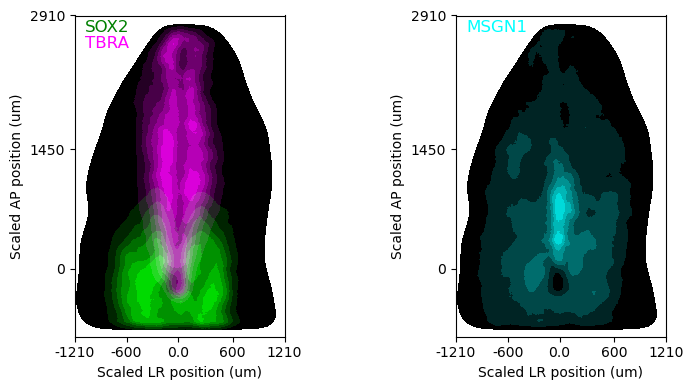

In [40]:
channel1, channel2, channel3 = channel_imgs

#resized image 
channel1 = ski.transform.rescale(channel1, 20, anti_aliasing=True)
channel2 = ski.transform.rescale(channel2, 20, anti_aliasing=True)
channel3 = ski.transform.rescale(channel3, 20, anti_aliasing=True)

mask_zero_resc = ski.transform.rescale(mask_zero, 20)

#smooth the mask
mask_zero_resc = ski.filters.gaussian(mask_zero_resc, sigma=30, mode='constant', cval=0)
mask_zero_resc = mask_zero_resc > 0.5

#Set nans to 0
channel1[np.isnan(channel1)] = 0
channel2[np.isnan(channel2)] = 0
channel3[np.isnan(channel3)] = 0


channel1[~mask_zero_resc] = np.nan
channel2[~mask_zero_resc] = np.nan
channel3[~mask_zero_resc] = np.nan

#Set mask where image is nan
maskNan = np.isnan(channel1)
bins = 8

# #Digitize the image channels into 10 bins
channel1 = np.digitize(channel1, np.linspace(np.nanmin(channel1), np.nanmax(channel1),bins)).astype(float)
channel2 = np.digitize(channel2, np.linspace(np.nanmin(channel2), np.nanmax(channel2), bins)).astype(float)
channel3 = np.digitize(channel3, np.linspace(np.nanmin(channel3), np.nanmax(channel3), bins)).astype(float)

# Set nans for the background mask
channel1[maskNan] = np.nan
channel2[maskNan] = np.nan
channel3[maskNan] = np.nan

# Normalize each channel if they aren’t already between 0 and 1
channel1 = (channel1 - np.nanmin(channel1)) / np.nanmax(channel1- np.nanmin(channel1))
channel2 = (channel2 - np.nanmin(channel2)) / np.nanmax(channel2- np.nanmin(channel2))
channel3 = (channel3 - np.nanmin(channel3)) / np.nanmax(channel3- np.nanmin(channel3))


# Map each channel to its respective color
green = np.stack([np.zeros_like(channel1), channel1, np.zeros_like(channel1)], axis=2) # Green
magenta = np.stack([channel2, np.zeros_like(channel2), channel2], axis=2)             # Magenta
cyan = np.stack([np.zeros_like(channel3),  channel3, channel3], axis=2)  # cyan

# Combine them by adding the colors together
rgb_image = np.clip(green + magenta, 0, 1)  # Clip to avoid overflow
rbg_msgn1_img = np.clip(cyan, 0, 1)

#Scale the custom ticks by the upscaling (20)
ant_limit_sc = ant_limit * 20
LR_mid_sc = LR_mid * 20
post_lim_sc = post_lim * 20
ant_cut_sc = ant_cut * 20


fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# Display the final RGB image

def round_to_10(x):
    return int(10 * round(float(x)/10))


axes[0].imshow(rgb_image, origin='lower', interpolation='nearest')
axes[0].contour(outline, levels=[0.5], colors='white', linewidths=0.4, alpha = 0.5)
axes[0].contour(outline, levels=[0.5], colors='white', linewidths=0.4, alpha = 0.5)

axes[0].set_xticks([0, LR_mid_sc/2,LR_mid_sc, channel1.shape[1] - LR_mid_sc/2, channel1.shape[1]])        # Custom x-axis ticks
axes[0].set_xticklabels([round_to_10(-(LR_length/2)),
                       round_to_10(-(LR_length/4)), 
                       0.0, 
                       round_to_10(LR_length/4), 
                       round_to_10(LR_length/2)])

ymid = (post_lim_sc-ant_limit_sc)/2 + ant_cut_sc*2
 
axes[0].set_yticks([ant_limit_sc, ymid, post_lim_sc ])        # Custom x-axis ticks
axes[0].set_yticklabels([0, int(PS_length/20)*10, int(PS_length/10)*10])

#set xy labels
axes[0].set_xlabel('Scaled LR position (um)')
axes[0].set_ylabel('Scaled AP position (um)')
axes[0].set_aspect('equal')

# Add labels to color bar green = SOX2, magenta = TBRA
axes[0].text(0.05, 0.95, 'SOX2', color='green', fontsize=12, transform=axes[0].transAxes)
axes[0].text(0.05, 0.90, 'TBRA', color='magenta', fontsize=12, transform=axes[0].transAxes)

#Plot msgn1 image
axes[1].imshow(rbg_msgn1_img, origin='lower', interpolation='nearest')
axes[1].contour(outline, levels=[0.5], colors='white', linewidths=0.4, alpha = 0.5)
axes[1].contour(outline, levels=[0.5], colors='white', linewidths=0.4, alpha = 0.5)
axes[1].set_xticks([0, LR_mid_sc/2,LR_mid_sc, channel1.shape[1] - LR_mid_sc/2, channel1.shape[1]])        # Custom x-axis ticks
axes[1].set_xticklabels([round_to_10(-(LR_length/2)),
                       round_to_10(-(LR_length/4)), 
                       0.0, 
                       round_to_10(LR_length/4), 
                       round_to_10(LR_length/2)])
axes[1].set_yticks([ant_limit_sc, ymid, post_lim_sc ])        # Custom x-axis ticks
axes[1].set_yticklabels([0, int(PS_length/20)*10, int(PS_length/10)*10])
axes[1].set_xlabel('Scaled LR position (um)')
axes[1].set_ylabel('Scaled AP position (um)')
axes[1].set_aspect('equal')
#Add label to color bar
axes[1].text(0.05, 0.95, 'MSGN1', color='cyan', fontsize=12, transform=axes[1].transAxes)

plt.tight_layout()

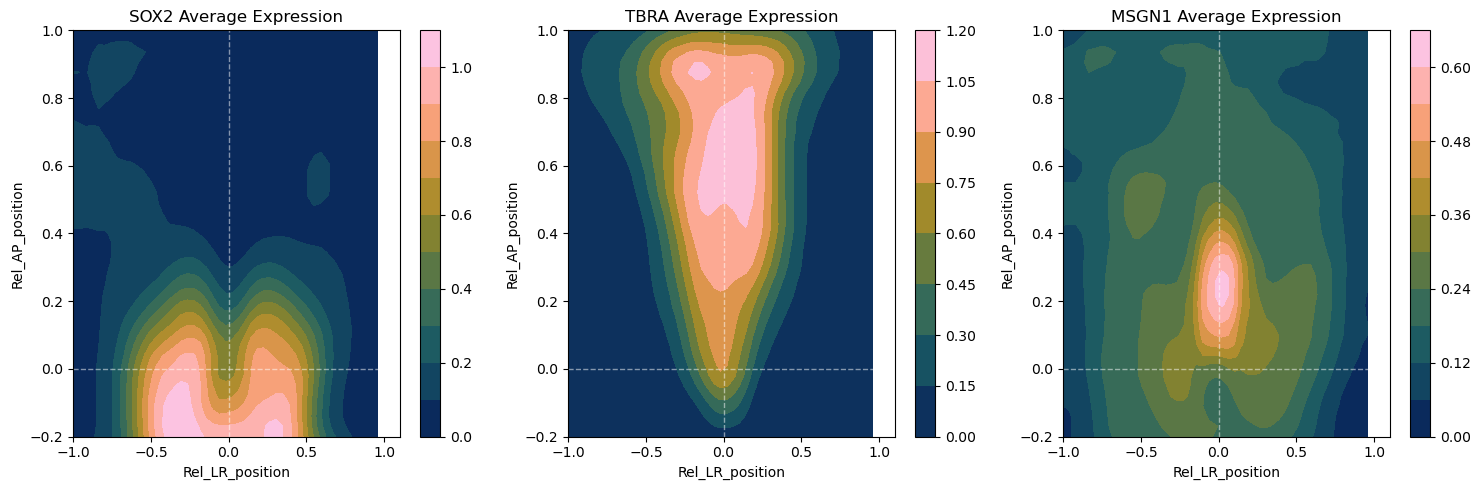

In [41]:
epi_nuc = all_cells[epi_mask]

# Assuming epi_nuc is a DataFrame
channels = ['SOX2', 'TBRA', 'MSGN1']
ycol = 'Rel_AP_position'
xcol = 'Rel_LR_position'

# Define binning
n_bins = 50
x_bins = np.linspace(epi_nuc[xcol].min(), epi_nuc[xcol].max(), n_bins)
y_bins = np.linspace(epi_nuc[ycol].min(), epi_nuc[ycol].max(), n_bins)

# Store average data for each channel
channel_avg_data = {}

# Bin data and average per replicate (e.g., per embryo)
for channel in channels:
    binned_data = []
    for embryo in epi_nuc['embryo'].unique():
        embryo_data = epi_nuc[epi_nuc['embryo'] == embryo]
        hist2d, _, _ = np.histogram2d((embryo_data[xcol]), 
                                        embryo_data[ycol], 
                                        bins=[x_bins, y_bins], 
                                        weights=embryo_data[channel])
        count, _, _ = np.histogram2d(embryo_data[xcol], 
                                    embryo_data[ycol], 
                                    bins=[x_bins, y_bins])
        avg = np.divide(hist2d, count, where=count != 0)
        binned_data.append(avg)

    # Average across embryos and store
    avg_data = np.nanmean(binned_data, axis=0)
    # Apply local mean smoothing
    smoothed_data = uniform_filter(avg_data, size=6, cval=np.nan)
    channel_avg_data[channel] = smoothed_data
    
# Create filled contour plots for all channels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, channel in zip(axes, channels):
    X, Y = np.meshgrid(x_bins[:-1], y_bins[:-1])
    CS = ax.contourf(X, Y, channel_avg_data[channel].T, cmap=cmc.batlow, levels=10)
    fig.colorbar(CS, ax=ax)
    ax.set_title(f'{channel} Average Expression')
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.set_ylim(-0.2, 1)
    ax.hlines(0, -1, 1, color='white', linestyle='--', alpha=0.5, linewidth=1)
    ax.vlines(0, -0.2, 1, color='white', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
# plt.savefig('combined_contours.png')
plt.show()
